# Test Semantic Segmentation

In [1]:
# !pip install jupyter ipywidgets --upgrade

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
import pathmagic

import gc
import torch.cuda as cuda

from config import cfg

from modules.model import JetSeg
from modules.utils import get_path, update_arch_cfg, pkl, color_map
from modules.mltools import (
    load_dataset, load_dataloaders, load_ckp, build_loss_fn,
    testing, batch_evaluation, inference_evaluation
)

from torchinfo import summary

from modules.vis import show_semantic, show_sample

In [4]:
# Cleaning 
gc.collect()
cuda.empty_cache()

In [5]:
# Set configuration
up_cfg = {"dataset_name": "camvid"}

# Update configuration
cfg = update_arch_cfg(cfg, up_cfg)

In [6]:
# Display model configuration
print(cfg.MODEL)

AFUNC: reu
CBAM_FMAPS: [480, 480, 240, 240]
DECODER_BLOCKS: [[8, 3, False, 128, 256, 128], [60, 2, False, 64, 128, 80], [240, 1, False, 40, 80, 48]]
DECODER_FMAPS: [8, 60, 240]
DECODER_HEADS_OUT: 192
ECA_FMAPS: [30, 30, 15, 15, 8, 8]
EFF: 2
ENCODER_ARCH: [[960, 0, False, 3, 48, 32], [480, 1, True, 32, 32, 32], [480, 1, False, 32, 64, 40], [240, 1, True, 40, 40, 40], [240, 1, False, 40, 80, 48], [120, 2, True, 48, 48, 48], [120, 2, False, 48, 96, 64], [60, 2, True, 64, 64, 64], [60, 2, False, 64, 128, 80], [30, 2, True, 80, 80, 80], [30, 2, False, 80, 160, 96], [15, 3, True, 96, 96, 96], [15, 3, False, 96, 192, 128], [8, 3, True, 128, 128, 128], [8, 3, False, 128, 256, 128]]
IBF: 32
IEFF: 1.5
LAST_FEATURES: 192
MAX_EXP_FEATURES: 256
MAX_FEATURES: 128
NUM_BLOCKS: 15
OBF: 8
SA_FMAPS: [120, 120, 60, 60]
SFF: 2


In [7]:
# Load data
cfg.DATASET.BATCH_SIZE = 8

datasets = load_dataset(cfg)
dataloaders = load_dataloaders(datasets, cfg)

In [8]:
# Build model
model = JetSeg(cfg)

In [9]:
# Get model checkpoint
model_path = get_path("train")
model_name = "JetSeg-" + cfg.DATASET.NAME.lower() + ".pth"
ckp_model = model_path + model_name

# Create checkpoint model
ckp_cfg = {}
ckp_cfg["model_ckp"] = ckp_model
ckp_cfg["model"] = model

# Loading model weights
model = load_ckp(ckp_cfg, mode=False)
model = model.to("cuda")

In [10]:
# Get torch summary
summary(model, input_size=(1, 3, cfg.DATASET.IMAGE_SIZE[0], cfg.DATASET.IMAGE_SIZE[1]))

/home/malopez/miniconda3/envs/nips2023/lib/python3.8/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/home/malopez/miniconda3/envs/nips2023/lib/python3.8/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                                       Output Shape              Param #
JetSeg                                                       [1, 32, 960, 720]         --
├─JetNet: 1-1                                                [1, 128, 8, 6]            --
│    └─ModuleList: 2-1                                       --                        --
│    │    └─JetBlock: 3-1                                    [1, 32, 480, 360]         (202)
│    │    └─JetBlock: 3-2                                    [1, 32, 480, 360]         (930)
│    │    └─JetBlock: 3-3                                    [1, 40, 240, 180]         (4,578)
│    │    └─JetBlock: 3-4                                    [1, 40, 240, 180]         (1,218)
│    │    └─JetBlock: 3-5                                    [1, 48, 120, 90]          (5,698)
│    │    └─JetBlock: 3-6                                    [1, 48, 120, 90]          (912)
│    │    └─JetBlock: 3-7                                    [1, 64, 60

In [11]:
# Test configuration
cfg.SOLVER.EPOCHS = 1

# Getting test path
test_path = get_path("test")

# Build loss fn
loss_fn = build_loss_fn(cfg)


# Setting up configuration paratemers
params = {}

params["debug"] = True
params["num_epochs"] = cfg.SOLVER.EPOCHS
params["early_stop"] = False
params["dataloaders"] = dataloaders
params["model"] = model
params["model_path"] = test_path
params["device"] = "cuda"
params["loss_fn"] = loss_fn

# Testing
loss, miou = testing(params)

Val/Test: 100%|█████████████████████████████████████████████████████████████████████| 29/29 [01:29<00:00,  3.10s/it]


| Test Loss 0.6946829023032353, mIoU 0.35070581888330393



In [12]:
# Get color map
data_path = get_path("data")
data_path += cfg.DATASET.NAME.lower() + "/"
color_dict = data_path + 'class_dict.csv'
code2id, id2code, name2id, id2name = color_map(color_dict)

In [13]:
# Batch evaluation of the model

# Load data
cfg.DATASET.BATCH_SIZE = 1
datasets = load_dataset(cfg)
dataloaders = load_dataloaders(datasets, cfg)

params["dataloaders"] = dataloaders
params["color_map"] = id2code
params["n_samples"] = 4

# Get test inferences for N samples
batch_out = batch_evaluation(params)

In [14]:
# Extract orig imgs and its inferences
imgs = list(batch_out[0])
masks = list(batch_out[1])
outs = list(batch_out[2])

# Apply transpose to outs
outs = [out.transpose(1, 2, 0) for out in outs]

print(imgs[0].shape)
print(masks[0].shape)
print(outs[0].shape)

(1, 3, 720, 960)
(1, 720, 960, 3)
(720, 960, 3)


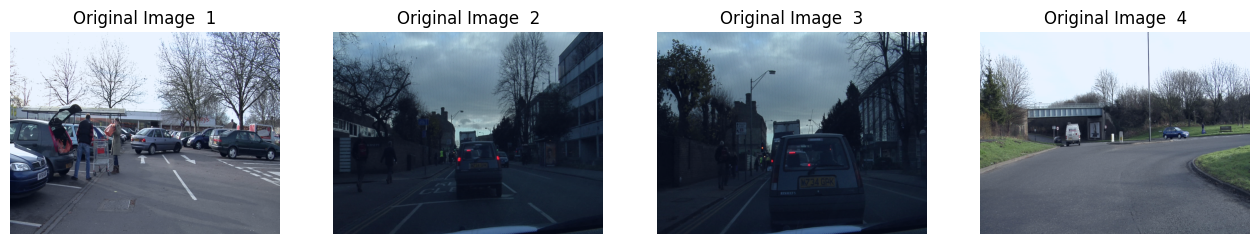

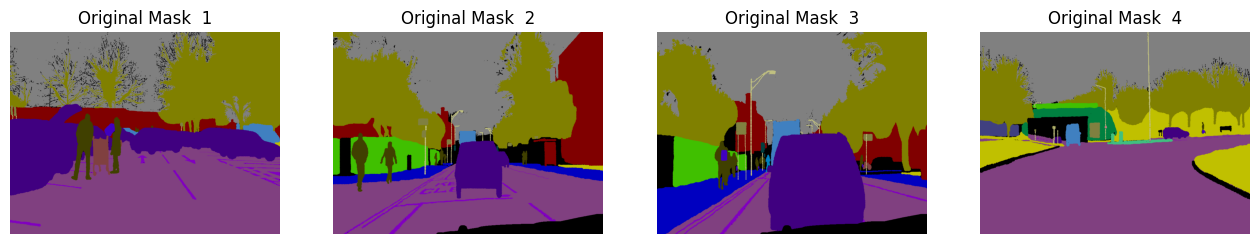

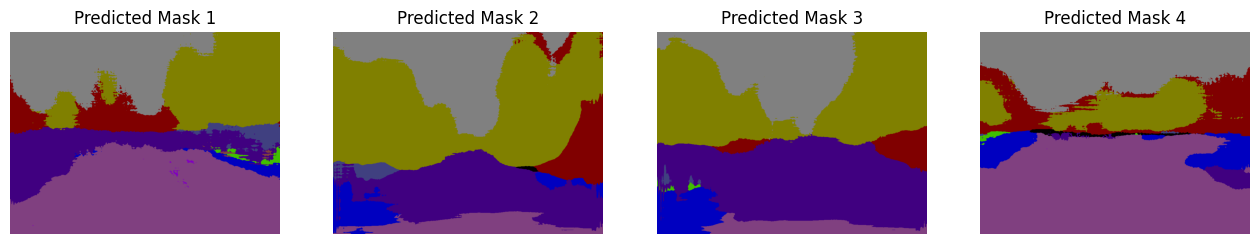

In [15]:
# Show semantic segmentation
show_semantic(imgs, "Original Image ", cols=4)
show_semantic(masks, "Original Mask ", cols=4, semantic=True)
show_semantic(outs, "Predicted Mask", cols=4, semantic=True)

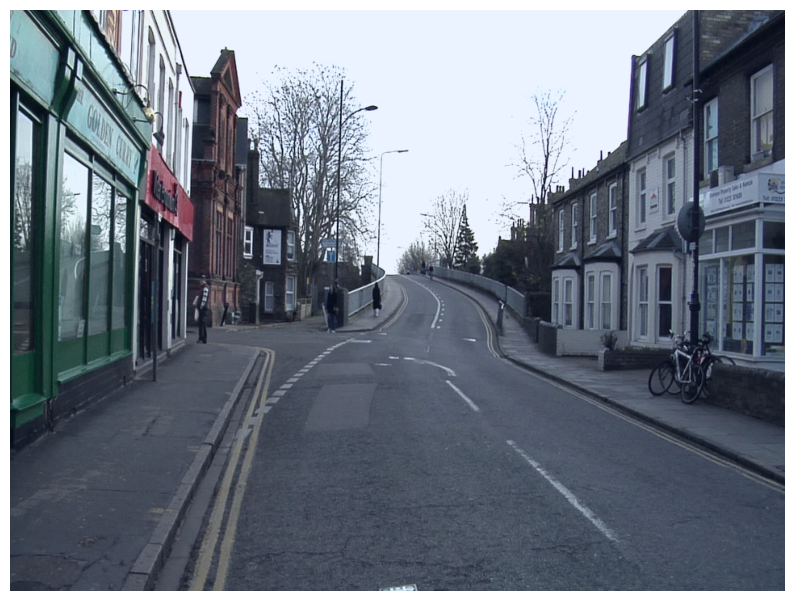

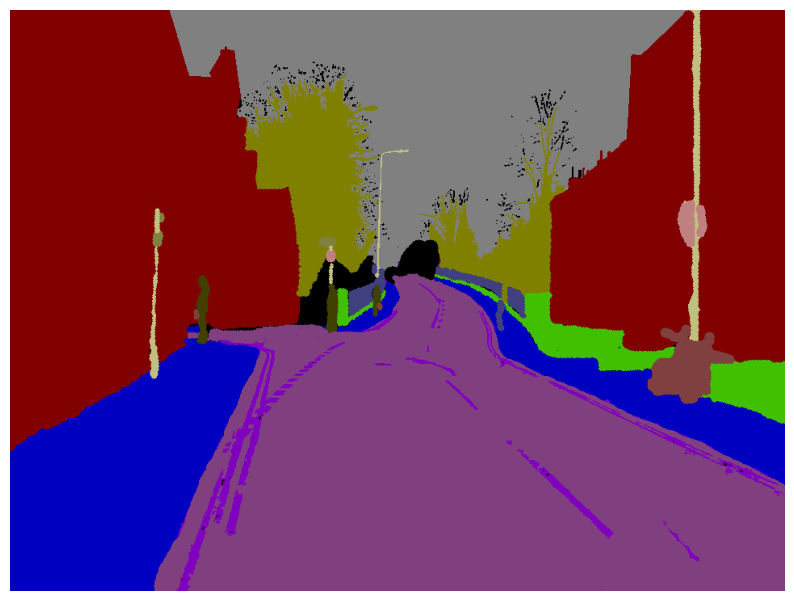

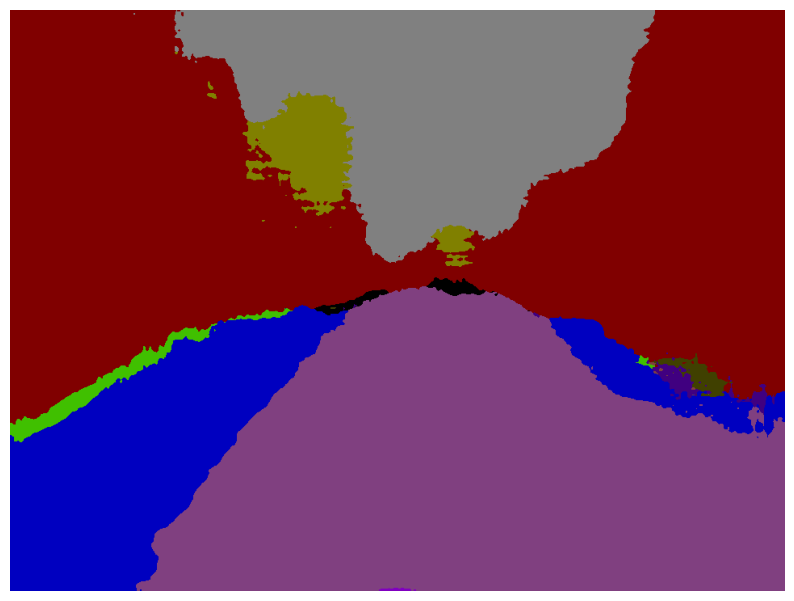

In [16]:
# Inference evaluation of the model

# Getting random sample
x, y, z = datasets["test"].get_random_sample()

# Showing sample
show_sample(x, semantic=False)

# Showing label
show_sample(z, semantic=True)

# Inference evaluation of the model
out = inference_evaluation(x, id2code, model, "cuda")

# Transpose
out = out.transpose(1, 2, 0)

# Showing inference
show_sample(out, semantic=True)